In [2]:
pip install pandas numpy scikit-learn tensorflow


Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.13.1-cp38-cp38-macosx_12_0_arm64.whl.metadata (2.6 kB)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Using cached tensorflow_macos-2.13.0-cp38-cp38-macosx_12_0_arm64.whl.metadata (3.2 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-4.25.5-cp37-abi3-macosx_10_9_universal2.whl.metadata (541 bytes)
  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
  U

In [3]:
pip install --upgrade pandas numpy scikit-learn tensorflow


Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.24.4-cp38-cp38-macosx_11_0_arm64.whl.metadata (5.6 kB)
  Using cached tensorflow-2.13.1-cp38-cp38-macosx_12_0_arm64.whl.metadata (2.6 kB)
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load datasets
xlsx_path = 'ev_battery_data.xlsx'
mock_csv_path = 'Mock_Balanced_Gassing_Data.csv'

xlsx_data = pd.read_excel(xlsx_path)
mock_data = pd.read_csv(mock_csv_path)

# Data Preprocessing

# Select relevant columns from xlsx_data
relevant_columns = [
    'Battery Temperature (Start) [°C]',
    'Battery Temperature (End)',
    'Battery State of Charge (Start)',
    'Battery State of Charge (End)'
]
filtered_xlsx_data = xlsx_data[relevant_columns].dropna()

# Rename columns for clarity
filtered_xlsx_data.rename(columns={
    'Battery Temperature (Start) [°C]': 'Temperature_Start',
    'Battery Temperature (End)': 'Temperature_End',
    'Battery State of Charge (Start)': 'SOC_Start',
    'Battery State of Charge (End)': 'SOC_End'
}, inplace=True)

# Normalize the features from xlsx_data
scaler = MinMaxScaler()
normalized_xlsx_features = scaler.fit_transform(filtered_xlsx_data)

# Extract features and target from the Mock Balanced Gassing Dataset
mock_features = mock_data[['Temperature', 'State of Charge']].values
mock_target = mock_data['Gassing'].values

# Adjust xlsx data length to match the CSV dataset
mock_aligned_features = np.tile(normalized_xlsx_features, (len(mock_features) // len(normalized_xlsx_features) + 1, 1))[:len(mock_features)]

# Combine normalized xlsx features with CSV features
mock_combined_features = np.hstack([mock_aligned_features, mock_features])

# Split data into train-test sets
mock_X_train, mock_X_test, mock_y_train, mock_y_test = train_test_split(mock_combined_features, mock_target, test_size=0.2, random_state=42)

# Reshape data for LSTM input (samples, timesteps, features)
mock_X_train = mock_X_train.reshape((mock_X_train.shape[0], 1, mock_X_train.shape[1]))
mock_X_test = mock_X_test.reshape((mock_X_test.shape[0], 1, mock_X_test.shape[1]))

# Define and compile the LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(32, input_shape=input_shape, return_sequences=False),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

input_shape = (mock_X_train.shape[1], mock_X_train.shape[2])
mock_model = create_lstm_model(input_shape)

# Train the model
mock_model.fit(mock_X_train, mock_y_train, epochs=10, batch_size=32, validation_data=(mock_X_test, mock_y_test), verbose=1)

# Evaluate the model
mock_loss, mock_mae = mock_model.evaluate(mock_X_test, mock_y_test, verbose=0)
print(f"Mock Dataset - Loss (MSE): {mock_loss}, MAE: {mock_mae}")

# Save the model
mock_model.save("mock_gassing_model.h5")


Epoch 1/10
45/45 [==============================] - 1s 6ms/step - loss: 0.3436 - mae: 0.4943 - val_loss: 0.2256 - val_mae: 0.4664
Epoch 2/10
45/45 [==============================] - 0s 1ms/step - loss: 0.2141 - mae: 0.4478 - val_loss: 0.1764 - val_mae: 0.4084
Epoch 3/10
45/45 [==============================] - 0s 1ms/step - loss: 0.1569 - mae: 0.3700 - val_loss: 0.1090 - val_mae: 0.3008
Epoch 4/10
45/45 [==============================] - 0s 1ms/step - loss: 0.1071 - mae: 0.2800 - val_loss: 0.0775 - val_mae: 0.2314
Epoch 5/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0932 - mae: 0.2531 - val_loss: 0.0725 - val_mae: 0.2238
Epoch 6/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0874 - mae: 0.2415 - val_loss: 0.0688 - val_mae: 0.2088
Epoch 7/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0839 - mae: 0.2304 - val_loss: 0.0672 - val_mae: 0.2110
Epoch 8/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0783 - mae: 0.22

/opt/miniconda3/envs/myenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
mock_history = mock_model.fit(mock_X_train, mock_y_train, 
                              epochs=10, 
                              batch_size=32, 
                              validation_data=(mock_X_test, mock_y_test), 
                              verbose=1)


Epoch 1/10
45/45 [==============================] - 0s 2ms/step - loss: 0.0686 - mae: 0.2054 - val_loss: 0.0572 - val_mae: 0.1876
Epoch 2/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0673 - mae: 0.2028 - val_loss: 0.0553 - val_mae: 0.1825
Epoch 3/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0667 - mae: 0.2010 - val_loss: 0.0541 - val_mae: 0.1781
Epoch 4/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0649 - mae: 0.1982 - val_loss: 0.0536 - val_mae: 0.1750
Epoch 5/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0646 - mae: 0.1922 - val_loss: 0.0510 - val_mae: 0.1703
Epoch 6/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0633 - mae: 0.1889 - val_loss: 0.0499 - val_mae: 0.1670
Epoch 7/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0595 - mae: 0.1825 - val_loss: 0.0499 - val_mae: 0.1661
Epoch 8/10
45/45 [==============================] - 0s 1ms/step - loss: 0.0606 - mae: 0.18

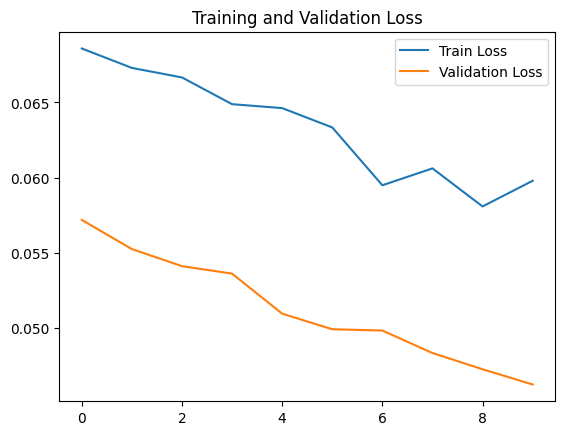

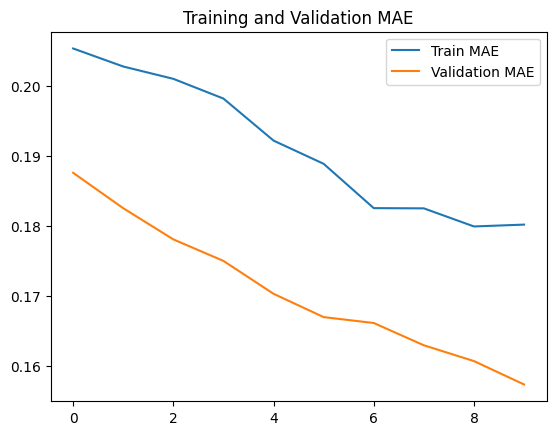

In [4]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(mock_history.history['loss'], label='Train Loss')
plt.plot(mock_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

# Plot MAE
plt.plot(mock_history.history['mae'], label='Train MAE')
plt.plot(mock_history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.title("Training and Validation MAE")
plt.show()
